# Postprocessing pty-co-SAXSNN for MATLAB (blee SAXS4Assembly + SAXSimageviewer packages)

In [10]:
import pandas as pd
import os
import sys
import torch
import numpy as np
from tqdm import tqdm
import time
import h5py
from scipy.io import loadmat,savemat
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter
import random

# Add parent directory to path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))
from utils.ptychosaxsNN_utils import load_h5_scan_to_npy, preprocess_ZCB_9
from utils.create_combined_h5_utils import get_processed_scans, save_to_h5, save_verification_plot, process_scan, add_metadata_to_h5, find_zero_arrays
from models.encoder1 import recon_model 

In [20]:
# Parameters
scan_name = 'ZCB_9_3D'
base_path = "/net/micdata/data2/12IDC/2025_Feb/ptycho/"

# Read the file, skipping the first row (which starts with #) and using the second row as headers
df = pd.read_csv('/net/micdata/data2/12IDC/2025_Feb/misc/ZCB_9_3D_/ZCB9_3D_alignment_shifts_28nm.txt', 
                comment='#',  # Skip lines starting with #
                names=['Angle', 'y_shift', 'x_shift', 'scanNo'])  # Specify column names
scan_numbers = df['scanNo'].values.tolist()

#scan_number=[5065]
center = (517, 575)
dpsize = 256

# Model and mask paths
# model_path = '/net/micdata/data2/12IDC/ptychosaxs/batch_mode/trained_model/best_model_LatticeClathII_Probe256x256_ZCB_9_3D__Noise_sim_ZCB_9_3D_S5065_N600_steps4_dp256_Unet_epoch_25_pearson_loss_symmetry_0.0.pth'
model_path = '../example/03_Train_Validation_Test/trained_model/best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss.pth'
mask_path = '../data/masks/mask_ZCB_9_3D.npy' 

# Load model and mask once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = recon_model()
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Load mask
mask = np.load(mask_path)

# Output H5 file
output_file = f'../example/05_Postprocessing/combined_diffraction_patterns_{scan_name}_{model_path.split("/")[-1].split(".")[0]}.h5'
print('output_file:', output_file)

# Get already processed scans
processed_scans = get_processed_scans(output_file)
remaining_scans = [s for s in scan_numbers if s not in processed_scans]
print(f"Found {len(processed_scans)} already processed scans. {len(remaining_scans)} scans remaining.")

# Add indices file parameter
indices_file = "../data/results/ZCB_9_3D_sample_indices_variance_threshold.h5" 

# Add delay parameter
delay_between_scans = 0.1  # seconds

output_file: ../example/05_Postprocessing/combined_diffraction_patterns_ZCB_9_3D_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss.h5
Found 1 already processed scans. 353 scans remaining.


In [ ]:
# Process remaining scans sequentially with delay
results = []
for scan_number in tqdm(remaining_scans[0:1], desc="Processing scans"):
    result = process_scan(
        scan_number=scan_number,
        base_path=base_path,
        model=model,
        device=device,
        center=center,
        dpsize=dpsize,
        mask=mask,
        indices_file=indices_file
    )
    if result is not None:
        results.append(result)
        save_verification_plot(result)
        save_to_h5(output_file, result)
    
    if scan_number != remaining_scans[-1]:  # Don't delay after the last scan
        print(f"\nWaiting {delay_between_scans} seconds before processing next scan...", flush=True)
        time.sleep(delay_between_scans)

print("Processing complete. Results saved to", output_file)

Processing scans:   0%|          | 0/1 [00:00<?, ?it/s]

Loading scan 5008


100%|██████████| 1044/1044 [00:08<00:00, 126.77it/s]


Using 125 selected indices for scan 5008

Waiting 0.1 seconds before processing next scan...


Processing scans: 100%|██████████| 1/1 [00:12<00:00, 12.02s/it]

Processing complete. Results saved to ../example/05_Postprocessing/combined_diffraction_patterns_ZCB_9_3D_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss.h5


In [ ]:
# Add metadata to H5 file
add_metadata_to_h5(output_file, df)

Successfully added metadata for 3 scans


True

# Convert h5 to mat

In [19]:
output_file = "../example/05_Postprocessing/combined_diffraction_patterns_ZCB_9_3D_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss.h5"
save_string = output_file.split("/")[-1].split(".")[0]
print(save_string)


combined_diffraction_patterns_ZCB_9_3D_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss


Skipping scan 5003
KeyError processing scan 5005: "Unable to synchronously open object (object 'scan_5005' doesn't exist)"
KeyError processing scan 5006: "Unable to synchronously open object (object 'scan_5006' doesn't exist)"
KeyError processing scan 5007: "Unable to synchronously open object (object 'scan_5007' doesn't exist)"
KeyError processing scan 5010: "Unable to synchronously open object (object 'scan_5010' doesn't exist)"
KeyError processing scan 5011: "Unable to synchronously open object (object 'scan_5011' doesn't exist)"
KeyError processing scan 5012: "Unable to synchronously open object (object 'scan_5012' doesn't exist)"
KeyError processing scan 5013: "Unable to synchronously open object (object 'scan_5013' doesn't exist)"
KeyError processing scan 5014: "Unable to synchronously open object (object 'scan_5014' doesn't exist)"
KeyError processing scan 5015: "Unable to synchronously open object (object 'scan_5015' doesn't exist)"
KeyError processing scan 5016: "Unable to syn

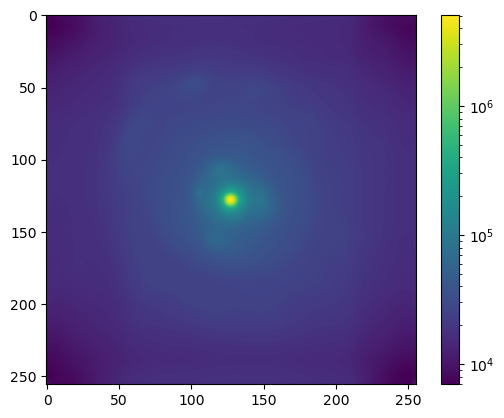

In [20]:
scan_num_start=5003
size=366
skip_indices=[0]#[1,2,3]
result_mtx=np.zeros((256,256,size))
angles=np.zeros((size))
valid_idx = 0  # Counter for valid entries
for i in range(0,size):
    if i in skip_indices:
        print(f"Skipping scan {scan_num_start+i}")
        continue
    else:
        with h5py.File(output_file, 'r') as f:
            try:
                #print(f"Processing scan {scan_num_start+i}")
                data = f['deconvolved'][f'scan_{scan_num_start+i}'][()]
                result_mtx[:,:,valid_idx]=data
                
                # Get the scan number and find its index in the scan_numbers array
                current_scan = scan_num_start + i
                scan_numbers = f['metadata']['scan_numbers'][()]
                angle_idx = np.where(scan_numbers == current_scan)[0]
                
                if len(angle_idx) > 0:
                    angles[valid_idx] = f['metadata']['angles'][()][angle_idx[0]]
                else:
                    print(f"Warning: No angle found for scan {current_scan}. Using previous angle.")
                    angles[valid_idx] = angles[valid_idx-1] if valid_idx > 0 else 0
                
                valid_idx += 1
            except KeyError as e:
                print(f"KeyError processing scan {scan_num_start+i}: {str(e)}")
            except IndexError as e:
                print(f"IndexError processing scan {scan_num_start+i}: {str(e)}")
            except Exception as e:
                print(f"Error processing scan {scan_num_start+i}: {str(e)}")
                
zero_idx = find_zero_arrays(result_mtx)
print(f"Found zero arrays at indices: {zero_idx}")

# Find the index with maximum sum
sums = np.array([np.sum(result_mtx[:,:,i]) for i in range(result_mtx.shape[2])])
max_idx = np.argmax(sums)
print(f"Found maximum sum at index: {max_idx}")

# Combine zero indices with max index
indices_to_remove = list(set(zero_idx + [max_idx]))
print(f"Removing indices: {indices_to_remove}")

# Create masks for valid arrays
valid_mask = np.ones(result_mtx.shape[2], dtype=bool)
valid_mask[indices_to_remove] = False

# Remove invalid arrays and their corresponding angles
result_mtx = result_mtx[:,:,valid_mask]
angles = angles[valid_mask]

print(f"Removed {len(indices_to_remove)} arrays. New shape: {result_mtx.shape}")

# Apply Gaussian smoothing to each frame
sigma = 1  # Adjust this value to control the amount of smoothing
for i in range(result_mtx.shape[2]):
    result_mtx[:,:,i] = gaussian_filter(result_mtx[:,:,i], sigma=sigma)

final = {'img':result_mtx,'phi':angles}

plt.figure()
plt.imshow(result_mtx[:,:,0], norm=LogNorm())
plt.colorbar()
plt.show()

result_mtx_processed = result_mtx.copy()


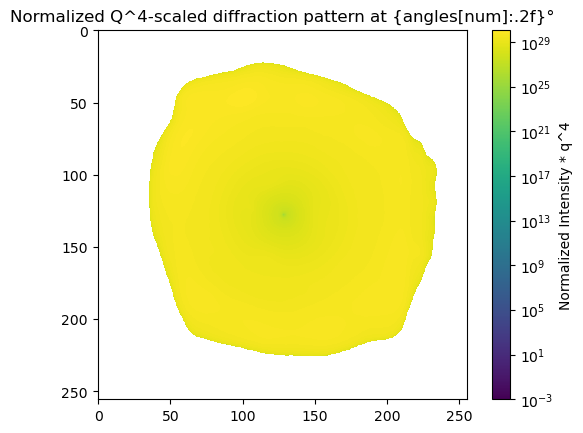

Saved mat file


In [21]:
# Calculate q values
detector_pixel_size = 172e-6  # 75 microns in meters
sample_detector_distance = 10  # meters
wavelength = 1.24e-10  # angstroms to meters
num_pixels = result_mtx.shape[0]  # Assuming square detector

# Create pixel coordinate arrays
x = np.arange(-num_pixels//2, num_pixels//2)
X, Y = np.meshgrid(x, x)
R = np.sqrt(X**2 + Y**2)

# Calculate scattering angle and q
theta = np.arctan(detector_pixel_size * R / sample_detector_distance)
q = 4 * np.pi * np.sin(theta) / wavelength

# Number of slices you want to plot
num_slices_to_plot = 1
# Randomly select indices to plot
indices_to_plot = random.sample(range(result_mtx.shape[2]), num_slices_to_plot)

# Postprocessing parameters
scale_exponent = 4
norm_max=True
subtract_background=True
save_mat=True

for num in range(result_mtx.shape[2]):
    # Calculate q values, assuming X, Y, R, theta, and q are already defined as needed above
    
    # Background subtraction using the median for each slice
    background = np.median(result_mtx[:, :, num])
    # Background estimation using Gaussian filtering
    if subtract_background:
        result_mtx_selected = result_mtx[:, :, num] - background
    else:
        result_mtx_selected = result_mtx[:, :, num]

    # Remove NaN values
    result_mtx_selected = np.nan_to_num(result_mtx_selected)
    
    # Intensity normalization
    if norm_max:
        max_intensity = np.max(result_mtx_selected)
        if max_intensity != 0:
            result_mtx_selected /= max_intensity
    else:
        result_mtx_selected = result_mtx_selected

    # Scaling by q^4 (example)
    scaled_image = result_mtx_selected * q**scale_exponent

    # Plot only selected slices
    if num in indices_to_plot:
        plt.figure()
        plt.imshow(scaled_image, norm=LogNorm(vmin=1e-3))
        plt.colorbar(label='Normalized Intensity * q^'+str(scale_exponent))
        plt.title(f'Normalized Q^'+str(scale_exponent)+'-scaled diffraction pattern at {angles[num]:.2f}°')
        plt.show()
        
    result_mtx_processed[:,:,num] = scaled_image

final = {'img':result_mtx_processed,'phi':angles}

if save_mat:
    savemat("../example/05_Postprocessing/"+save_string+"_processed.mat",final)
    print("Saved mat file")
else:
    print("Not saving mat file")

In [22]:
save_string

'combined_diffraction_patterns_ZCB_9_3D_best_model_Lattice400_Typeclathrate_II_DP256_Sim256_Grid1024_nsteps4_nscans60_centerConc0_sim_ZCB_9_3D_S5065_N60_steps4_dp256_Unet_epoch_10_pearson_loss'